In [2]:
# Standard library imports
import json
import gc
import os
from pathlib import Path
from typing import List, Optional

# Third-party library imports
import fire
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
from datasets import load_dataset
from torch import optim
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from mistral_common.protocol.instruct.messages import (
    UserMessage,
)
from mistral_common.protocol.instruct.request import ChatCompletionRequest
from mistral_common.tokens.tokenizers.mistral import MistralTokenizer

# Local application/library-specific imports
from mistral import ModelArgs, Transformer, RMSNorm, precompute_freqs_cis, generate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os
import logging
import datetime
import pickle
from tqdm import tqdm

c:\Users\leopu\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# # Load the dataset in streaming mode
# ds = load_dataset("HuggingFaceTB/cosmopedia", "stories", streaming=True,)

# # Initialize a counter
# counter = 0

# # Iterate over the dataset
# dataset = {
#     "text": [],
# }

# for sample in ds["train"]:
#     dataset["text"].append(sample["text"])
#     counter += 1
#     if counter >= 1000:
#         break

In [4]:
# def save_data(dataset_dict): 
#     with open('data/cosmopedia.pkl', 'wb') as f:
#         pickle.dump(dataset_dict, f)

# save_data(dataset)

In [5]:
def load_data():
    with open('data/cosmopedia.pkl', 'rb') as f:
        dataset = pickle.load(f)
    return dataset

dataset = load_data()

In [6]:
# Load the tokenizer outside of the function
tokenizer = MistralTokenizer.v1()

def tokenize_text(text, tokenizer, return_text=False):
    # Tokenize the input text using the provided tokenizer
    tokenized = tokenizer.encode_chat_completion(
        ChatCompletionRequest(
            messages=[UserMessage(content=text)],
            model="open-mistral-7b",
        )
    )

    tokens = tokenized.tokens
    tokenized_text = tokenized.text

    if return_text:
        return tokens, tokenized_text
    else:
        return tokens

In [7]:
tokenize_text("hello my name is Leo", tokenizer, return_text=True)

([1,
  733,
  16289,
  28793,
  6312,
  28709,
  586,
  1141,
  349,
  19795,
  733,
  28748,
  16289,
  28793],
 '<s>▁[INST]▁hello▁my▁name▁is▁Leo▁[/INST]')

In [8]:
dataset["text"][:5]

[' Once upon a time, in a village called Kiwiland, there lived two best friends named Kiwi and Koala. They loved exploring the world around them and learning new things every day! One day, they stumbled upon a magical forest full of vibrant colors and fascinating creatures. As they ventured deeper into the forest, they met Torty, a wise old turtle who was known to have answers to all questions.\n\nKiwi asked Torty, "How does our culture affect the way we make decisions?" Torty smiled and replied, "Well my dear friend, let me tell you a story."\n\nLong ago, in another part of the forest, there were two tribes - the Hares and the Sloths. The Hares valued speed and quickness, believing that swift actions led to success. On the other hand, the Sloths cherished patience and deliberation, thinking that slow yet thoughtful decisions brought prosperity.\n\nOne sunny afternoon, both tribes faced a challenge – sharing a limited supply of fruits between them. The Hares wanted to divide the fruits

In [9]:
max_seq_len = 1024

class PaddedSequenceTokenDataset(Dataset):
    def __init__(self, texts, vocab_size, max_seq_len):
        self.texts = texts
        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokenized_text = torch.tensor(tokenize_text(text, tokenizer), dtype=torch.long, requires_grad=False)
        padded_sequence = torch.nn.functional.pad(tokenized_text, (0, self.max_seq_len - len(tokenized_text)), "constant", 0)  # Pad on the left
        return padded_sequence

vocab_size = 10000  # This is the size of your vocabulary
padded_dataset = PaddedSequenceTokenDataset(dataset["text"], vocab_size, max_seq_len)

In [10]:
batch_size = 1 # This is the size of the batches you want to load
data_loader = DataLoader(padded_dataset, batch_size=batch_size, num_workers=0, pin_memory=False)

In [11]:
for batch in data_loader:
    print(batch[:100])
    break

tensor([[    1,   733, 16289,  ...,     0,     0,     0]])


In [12]:
# Create a new ModelArgs object with the desired configuration
model_args = ModelArgs(
    dim=128,
    n_layers=2,
    head_dim=4,
    hidden_dim=128,
    n_heads=4,
    n_kv_heads=4,
    vocab_size=32000,
    norm_eps=1e-5,
    max_batch_size=3,
)

# Create a new Transformer object with random weights
model = Transformer(model_args).to("cuda", dtype=torch.float32)
#model = torch.compile(model)

In [13]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Transformer                              --
├─Embedding: 1-1                         4,096,000
├─ModuleList: 1-2                        --
│    └─TransformerBlock: 2-1             --
│    │    └─Attention: 3-1               8,192
│    │    └─FeedForward: 3-2             49,152
│    │    └─RMSNorm: 3-3                 128
│    │    └─RMSNorm: 3-4                 128
│    └─TransformerBlock: 2-2             --
│    │    └─Attention: 3-5               8,192
│    │    └─FeedForward: 3-6             49,152
│    │    └─RMSNorm: 3-7                 128
│    │    └─RMSNorm: 3-8                 128
├─RMSNorm: 1-3                           128
├─Linear: 1-4                            4,096,000
Total params: 8,307,328
Trainable params: 8,307,328
Non-trainable params: 0

In [14]:
# Get the number of bytes currently allocated on the GPU
allocated_bytes = torch.cuda.memory_allocated()

# Convert to megabytes
allocated_mb = allocated_bytes / 1_048_576

print(f'Memory allocated by PyTorch on the GPU: {allocated_mb:.2f} MB')

Memory allocated by PyTorch on the GPU: 46.39 MB


In [15]:
num_params = sum(p.numel() for p in model.parameters())
num_buffers = sum(b.numel() for b in model.buffers())

# Convert to bytes
params_bytes = num_params * 4
buffers_bytes = num_buffers * 4

# Convert to megabytes
params_mb = params_bytes / 1_048_576
buffers_mb = buffers_bytes / 1_048_576

print(f'Number of parameters: {num_params}')
print(f'Number of buffers: {num_buffers}')
print(f'Memory for parameters: {params_mb:.2f} MB')
print(f'Memory for buffers: {buffers_mb:.2f} MB')

Number of parameters: 8307328
Number of buffers: 0
Memory for parameters: 31.69 MB
Memory for buffers: 0.00 MB


In [16]:
# Create directories if they don't exist
os.makedirs('models', exist_ok=True)
os.makedirs('logs', exist_ok=True)

# Get current date and time
now = datetime.datetime.now()
date_time = now.strftime("%Y-%m-%d_%H-%M-%S")

# Find the next available run number
run_number = 0
while os.path.exists(f'logs/training-run-{run_number}-{date_time}.log'):
    run_number += 1

# Set up logging
logging.basicConfig(filename=f'logs/training-run-{run_number}-{date_time}.log', level=logging.INFO)

# Move model to GPU
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

positions = torch.arange(0, max_seq_len).to(device)

model.train()
num_epochs = 1
for epoch in range(num_epochs):
    for batch_idx, batch in enumerate(data_loader):
        input_ids = batch.to(device)

        logits = model.forward(input_ids, positions)
        logprobs = nn.functional.log_softmax(logits, dim=-1)

        with torch.no_grad():
            _, predicted = torch.max(logprobs, dim=2)

        loss = loss_fn(logprobs.view(-1, logprobs.size(-1)), input_ids.view(-1))
        print(f'\rEpoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item()}', end='')
        logging.info(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item()}')

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Delete variables that are no longer needed
        del logits, logprobs, predicted, loss

        # Save model checkpoint every 100 batches
        if (batch_idx + 1) % 500 == 0:
            torch.save(model.state_dict(), f'models/model_checkpoint_run-{run_number}_{date_time}_epoch-{epoch+1}_batch-{batch_idx}.pth')

    # Move model to CPU
    model.cpu()

    # Clear GPU memory and force garbage collection
    with torch.no_grad():
        torch.cuda.empty_cache()
    gc.collect()

    # Move model back to GPU
    model.to(device)

Epoch 1, Batch 999, Loss: 7.1582980155944825

In [30]:
prompt = "My Name is Leo"
generated_text, logprobs = generate([prompt], model, tokenizer, max_tokens=35)
print(generated_text[0])

[INST] My Name is Leo [/INST]<?acts publicationsbgSprintf syntax terr Finallymaticacingheaded insisted respon Čdatabase internet advice pointsSN steady tense afterwardsLOG Othersool Bushteen evolution anymoreImage removeonymOrigin disadv lasting


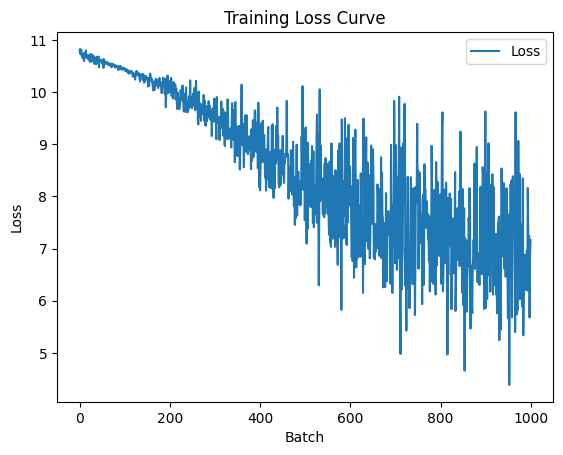

<Figure size 640x480 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt

# Read the log file
log_file_path = "logs/training-run-0-2024-07-02_21-02-05.log"
with open(log_file_path, "r") as file:
    lines = file.readlines()

# Initialize lists to store the parsed data
epochs = []
batches = []
losses = []

# Parse each line in the log file
for line in lines:
    if "Loss" in line:
        parts = line.strip().split(',')
        epoch = int(parts[0].split()[-1])
        batch = int(parts[1].split()[-1])
        loss = float(parts[2].split()[-1])
        
        epochs.append(epoch)
        batches.append(batch)
        losses.append(loss)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the loss values
ax.plot(range(len(losses)), losses, label="Loss")

# Set the title and labels
ax.set_title("Training Loss Curve")
ax.set_xlabel("Batch")
ax.set_ylabel("Loss")
ax.legend()

# Show the plot
plt.show()
plt.savefig("logs/loss.png")